# Deep Q-learning for trading

## Imports, Settings & Helpers

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample, choice
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

import os

### Settings

In [3]:
# np.random.seed(42)
# tf.random.set_seed(42)

In [4]:
sns.set_style('whitegrid')

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [6]:
experiment = 'experiment2'

In [7]:
training_number = None
try:
    if(len(os.listdir("results/{0}".format(experiment))) == 0):
        training_number = 1
    else:
        training_number = max(list(map(lambda dir: int(dir[8:]), os.listdir("results/{0}".format(experiment))))) + 1
except:
    training_number = 1
folder_id = 'training{0}'.format(training_number)
results_path = Path('results', experiment, folder_id)
print("results being saved at: {0}".format(results_path))
if not results_path.exists():
    results_path.mkdir(parents=True)

results being saved at: results\experiment2\training5


### Helper functions

In [8]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Set up Gym Environment

### Register Trading Environment

In [9]:
trading_days = 252

In [10]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days
)

### Initialize Trading Environment

In [11]:
trading_cost_bps = 1e-3
time_cost_bps = 1e-4

In [12]:
start_date = '1990-01-01'
end_date = '2018-03-20'

In [13]:
tickers = ['AAPL', 'JNJ']

In [14]:
trading_environment = gym.make('trading-v0', 
                               tickers=tickers,
                               trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps,
                               time_cost_bps=time_cost_bps,
                               start_date=start_date,
                               end_date=end_date)
# trading_environment.seed(42)

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for AAPL...
INFO:trading_env:got data for AAPL...
INFO:trading_env:preprocessing data for AAPL...
INFO:trading_env:finished preprocessing for AAPL...
INFO:trading_env:loading data for JNJ...
INFO:trading_env:got data for JNJ...
INFO:trading_env:preprocessing data for JNJ...
INFO:trading_env:finished preprocessing for JNJ...


### Get Environment Params

In [15]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

## Data understanding

In [16]:
df = trading_environment.data_source.data

### Full data set

In [17]:
df

,,returns,ret_2,ret_5,ret_10,ret_21,rsi,macd,atr,stoch,ultosc,bbp,obv,adx
date,ticker,,,,,,,,,,,,,
1990-02-16,AAPL,-0.011387,-0.342159,-0.272512,-0.256080,0.163860,-0.117316,-0.232982,-0.700450,1.216667,0.464362,-1.288541,-1.302059,-0.223342
1990-02-20,AAPL,-0.007407,-0.525718,-0.274236,-0.574896,-0.329297,-0.988709,-0.231034,-0.701863,1.497053,0.515331,-1.395079,-1.304272,-0.263464
1990-02-21,AAPL,0.014925,0.128937,-0.270814,-0.334876,0.012139,-0.531472,-0.229115,-0.700503,0.199937,0.731992,0.260195,-1.301114,-0.356855
1990-02-22,AAPL,-0.029412,-0.430855,-0.624106,-0.176205,-0.331788,-0.531472,-0.227846,-0.699908,-0.150682,0.137443,-1.528337,-1.304618,-0.470604
1990-02-23,AAPL,0.007576,-0.609662,-0.506908,-0.005907,-0.330533,-0.193910,-0.226857,-0.701360,-0.229833,0.163152,-0.683812,-1.301926,-0.552275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14,JNJ,-0.015110,-0.185511,0.794266,0.340902,0.067400,0.295039,-3.380704,4.655488,1.130522,-0.067955,-0.783975,2.108405,0.682172
2018-03-15,JNJ,0.005593,-0.568179,0.164122,1.039636,0.218529,-0.168773,-2.997722,4.525798,1.333623,0.044039,-0.286671,2.125365,0.507239
2018-03-16,JNJ,0.004660,0.479030,-0.134923,0.837965,0.350186,-0.527797,-2.618090,4.466504,1.206135,-0.013174,0.474627,2.172770,0.360851


--- Shape ---
Number of records: 14151
Number of attributes: 13

--- Types ---
returns    float64
ret_2      float64
ret_5      float64
ret_10     float64
ret_21     float64
rsi        float64
macd       float64
atr        float64
stoch      float64
ultosc     float64
bbp        float64
obv        float64
adx        float64
dtype: object

--- Statistical measures for each attribute ---
            returns         ret_2         ret_5        ret_10        ret_21  \
count  14151.000000  1.415100e+04  1.415100e+04  1.415100e+04  1.415100e+04   
mean       0.000864  1.305499e-17  2.736526e-17  1.707191e-17  6.025378e-18   
std        0.022149  1.000035e+00  1.000035e+00  1.000035e+00  1.000035e+00   
min       -0.518692 -1.376101e+01 -9.495202e+00 -7.187865e+00 -5.466655e+00   
25%       -0.008700 -5.033789e-01 -5.465183e-01 -5.685928e-01 -5.852319e-01   
50%        0.000092 -2.371287e-02 -4.439988e-03 -1.228723e-02 -3.113262e-02   
75%        0.010019  4.883591e-01  5.308260e-01  5.685751e

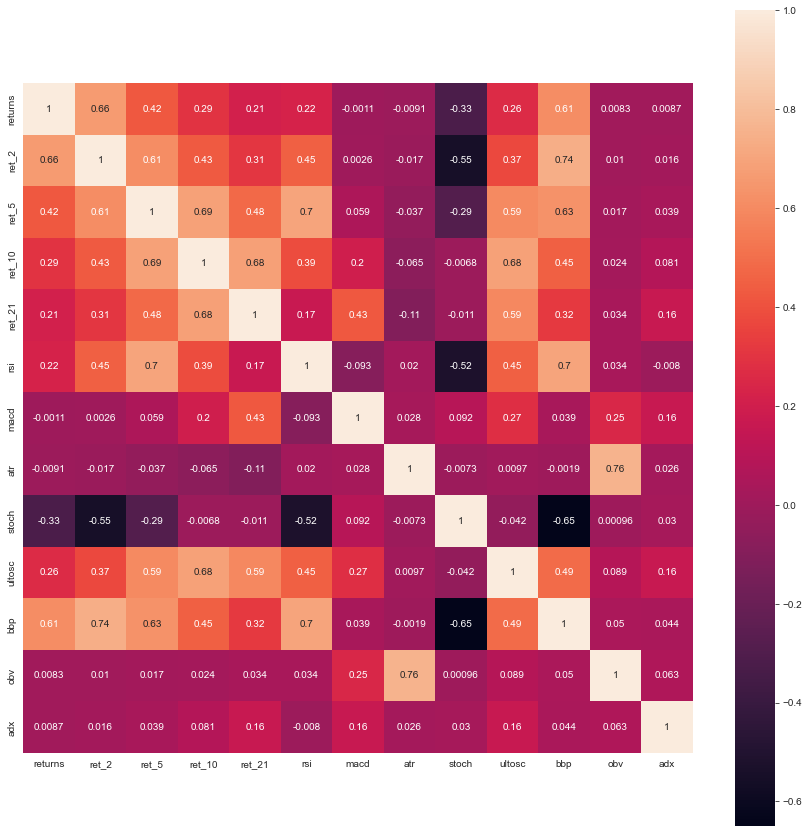

In [18]:
print("--- Shape ---")
print("Number of records:", df.shape[0])
print("Number of attributes:", df.shape[1])
print()
print("--- Types ---")
print(df.dtypes)
print()
print("--- Statistical measures for each attribute ---")
print(df.describe())
print()
print("--- Correlation ---")
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True)
plt.show()

### Per ticker data sets

AAPL
                    returns     ret_2     ret_5    ret_10    ret_21       rsi  \
date       ticker                                                               
1990-02-16 AAPL   -0.011387 -0.342159 -0.272512 -0.256080  0.163860 -0.117316   
1990-02-20 AAPL   -0.007407 -0.525718 -0.274236 -0.574896 -0.329297 -0.988709   
1990-02-21 AAPL    0.014925  0.128937 -0.270814 -0.334876  0.012139 -0.531472   
1990-02-22 AAPL   -0.029412 -0.430855 -0.624106 -0.176205 -0.331788 -0.531472   
1990-02-23 AAPL    0.007576 -0.609662 -0.506908 -0.005907 -0.330533 -0.193910   
...                     ...       ...       ...       ...       ...       ...   
2018-03-14 AAPL   -0.008501 -0.509170  0.221517 -0.107826  0.554053  0.060260   
2018-03-15 AAPL    0.001177 -0.240584  0.064389  0.106519  0.480562 -0.906354   
2018-03-16 AAPL   -0.003526 -0.115735 -0.264562 -0.012518  0.301082 -1.498085   
2018-03-19 AAPL   -0.015279 -0.526767 -0.655682 -0.224699 -0.083831 -1.498085   
2018-03-20 AAPL   -0.00

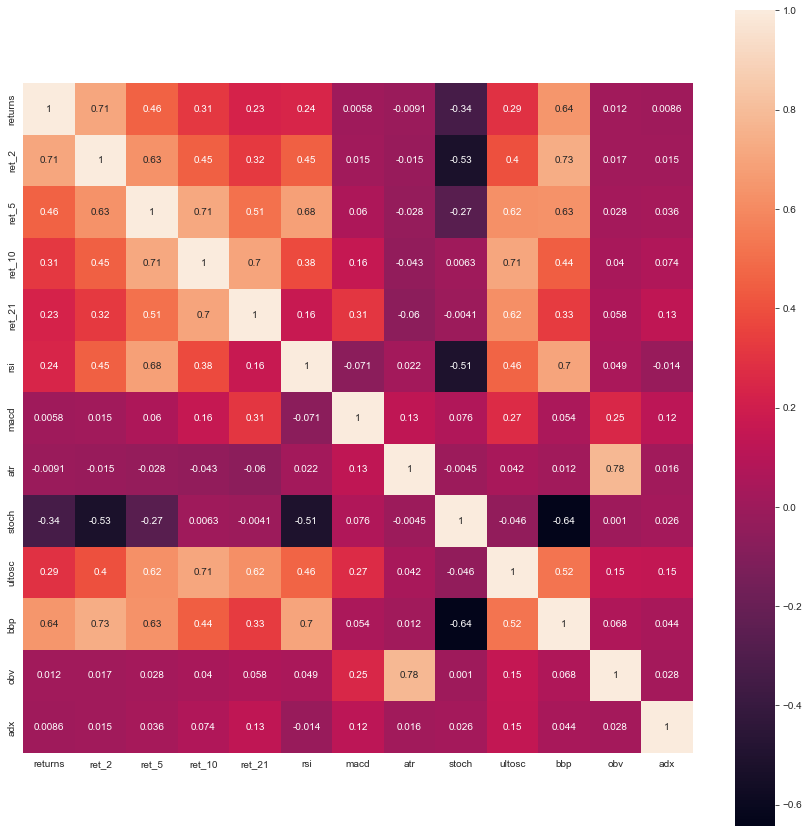

JNJ
                    returns     ret_2     ret_5    ret_10    ret_21       rsi  \
date       ticker                                                               
1990-02-16 JNJ    -0.015608 -0.062388 -0.309226  0.411298 -0.497667  0.535508   
1990-02-20 JNJ    -0.018018 -1.818904 -0.712949  0.107828 -1.066867 -0.173543   
1990-02-21 JNJ    -0.013761 -1.723368 -0.905749 -0.135885 -0.678325 -1.206511   
1990-02-22 JNJ    -0.011721 -1.396222 -1.617439 -0.799178 -0.849006 -1.584972   
1990-02-23 JNJ    -0.018825 -1.659842 -2.771215 -1.731521 -0.862307 -1.584972   
...                     ...       ...       ...       ...       ...       ...   
2018-03-14 JNJ    -0.015110 -0.185511  0.794266  0.340902  0.067400  0.295039   
2018-03-15 JNJ     0.005593 -0.568179  0.164122  1.039636  0.218529 -0.168773   
2018-03-16 JNJ     0.004660  0.479030 -0.134923  0.837965  0.350186 -0.527797   
2018-03-19 JNJ    -0.025733 -1.178790 -0.739539 -0.061132 -0.366058 -0.545756   
2018-03-20 JNJ     0.007

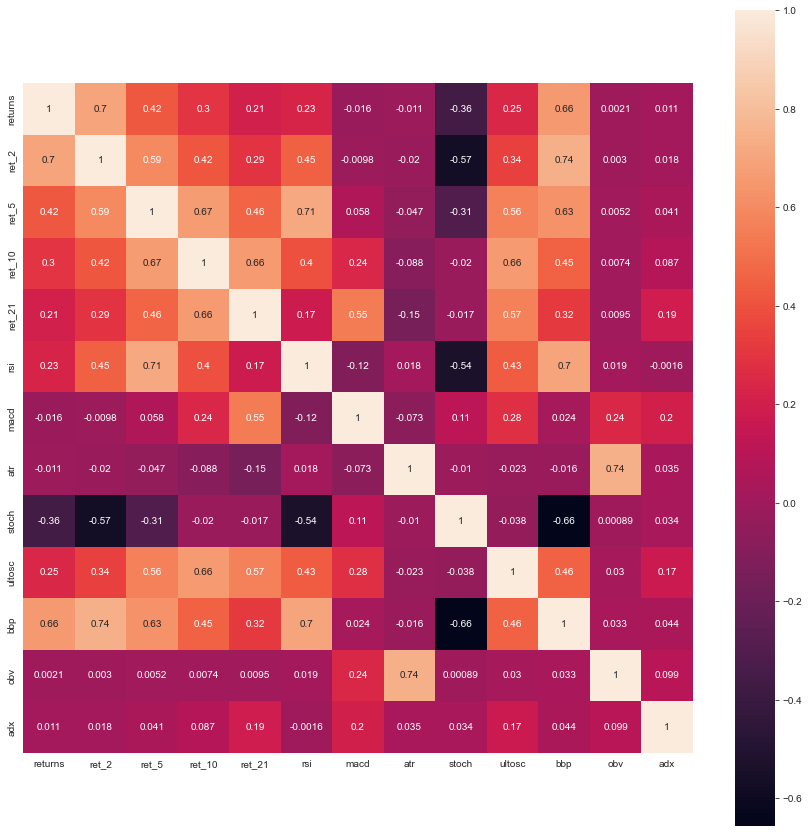

In [19]:
for ticker in tickers:
    print(ticker)
    df_ticker = df.loc[(slice(None), ticker), :]
    print(df_ticker)
    print("--- Shape ---")
    print("Number of records:", df_ticker.shape[0])
    print("Number of attributes:", df_ticker.shape[1])
    print()
    print("--- Types ---")
    print(df_ticker.dtypes)
    print()
    print("--- Statistical measures for each attribute ---")
    print(df_ticker.describe())
    print()
    print("--- Correlation ---")
    plt.figure(figsize=(15, 15))
    sns.heatmap(df_ticker.corr(), square=True, annot=True)
    plt.show()

## Define Trading Agent

In [20]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size,
                 train,
                 ticker):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg
        self.ticker = ticker

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        if(not train):
            self.epsilon = 0.0
        else:
            self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay

        self.total_steps = 0
        self.episodes = 0

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = train

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def load_model_weights(self, model_weights_filepath):
        self.online_network.load_weights(model_weights_filepath)
        print('model weights loaded from: ' + model_weights_filepath)
    
    def save_model_weights(self, folder_id):
        model_weights_filepath = 'weights/{0}/model_{1}.h5'.format(folder_id, self.ticker)
        if(not Path('weights/{0}'.format(folder_id)).exists()):
            Path('weights/{0}'.format(folder_id)).mkdir(parents=True)
        self.online_network.save_weights(model_weights_filepath)
        print('model weights saved at: ' + model_weights_filepath)

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state, verbose=0)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, done):
        if done:
            if self.episodes < self.epsilon_decay_steps:
                self.epsilon -= self.epsilon_decay
            else:
                self.epsilon *= self.epsilon_exponential_decay
            self.episodes += 1
        self.experience.append((s, a, r, s_prime, 0.0 if done else 1.0))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[(self.idx, actions)] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [21]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

### NN Architecture

In [22]:
architecture = (64, 64)  # units per layer
learning_rate = 0.001  # learning rate
l2_reg = 1e-6  # L2 regularization

### Experience Replay

In [23]:
replay_capacity = int(1e2)
batch_size = 1024

### $\epsilon$-greedy Policy

In [24]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

### Trainable

In [25]:
train = True
pickup = True # If train = False, set this variable to False as well. If train = True, it can be either True or False.

## Create DDQN Agent

In [26]:
tf.keras.backend.clear_session()

In [27]:
ddqn = {ticker: DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size,
                 train=train,
                 ticker=ticker) for ticker in tickers}

## Run Experiment

### Set parameters

In [28]:
total_steps = 0
max_episodes = 100

### Initialize variables

These variables will keep track of the agent results at the end of every episode

In [29]:
episode_time = []
navs = {ticker: [] for ticker in tickers}
market_navs = {ticker: [] for ticker in tickers}
diffs = {ticker: [] for ticker in tickers}
episode_eps = {ticker: [] for ticker in tickers}

### Load model weights

In [30]:
training_number = None
try:
    if(len(os.listdir("weights/{0}".format(experiment))) == 0):
        training_number = 1
    else:
        training_number = max(list(map(lambda dir: int(dir[8:]), os.listdir("weights/{0}".format(experiment)))))
except:
    training_number = 1
folder_id = '{0}/training{1}'.format(experiment, training_number)
model_weights_filepaths = {ticker: 'weights/{0}/model_{1}.h5'.format(folder_id, ticker) for ticker in tickers}
if(not train or pickup):
    for ticker in tickers:
        ddqn[ticker].load_model_weights(model_weights_filepaths[ticker])

model weights loaded from: weights/experiment2/training4/model_AAPL.h5
model weights loaded from: weights/experiment2/training4/model_JNJ.h5


### Modify epsilon start and episodes

In [31]:
if(pickup):
    trained_episodes = max(list(map(lambda dir: int(dir[8:]), os.listdir("weights/{0}".format(experiment)))))*max_episodes
    epsilon_decay_trained_episodes = trained_episodes if trained_episodes <= epsilon_decay_steps else epsilon_decay_steps
    epsilon_exponential_decay_trained_episodes = trained_episodes - epsilon_decay_steps if (trained_episodes - epsilon_decay_steps) > 0 else 0
    new_epsilon_start = epsilon_start - ((epsilon_start - epsilon_end) / epsilon_decay_steps)*epsilon_decay_trained_episodes
    new_epsilon_start = new_epsilon_start*(epsilon_exponential_decay**epsilon_exponential_decay_trained_episodes)
    for ticker in tickers:
        ddqn[ticker].epsilon = new_epsilon_start
        ddqn[ticker].episodes = trained_episodes
    print("Trained episodes: {0}".format(trained_episodes))
    print("Epsilon decay trained episodes: {0}".format(epsilon_decay_trained_episodes))
    print("Epsilon exponential decay trained episodes: {0}".format(epsilon_exponential_decay_trained_episodes))
    print("New epsilon start: {0}".format(new_epsilon_start))
    

Trained episodes: 400
Epsilon decay trained episodes: 250
Epsilon exponential decay trained episodes: 150
New epsilon start: 0.002214517872388611


### Visualization

In [32]:
training_number = None
try:
    if(len(os.listdir("training_outputs/{0}".format(experiment))) == 0):
        training_number = 1
    else:
        training_number = max(list(map(lambda dir: int(dir[8:]), os.listdir("training_outputs/{0}".format(experiment))))) + 1
except:
    training_number = 1
training_output_folder_id = 'training_outputs/{0}/training{1}'.format(experiment, training_number)
print("training outputs being saved at: {0}".format(training_output_folder_id))
if not Path(training_output_folder_id).exists():
    Path(training_output_folder_id).mkdir(parents=True)

training outputs being saved at: training_outputs/experiment2/training5


In [33]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon, ticker):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f} | {}'
    f = open(training_output_folder_id + "/training_output_" + ticker + ".txt", "a")
    print(template.format(episode, format_time(total), 
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon, ticker), file=f)
    f.close()

## Train Agent

In [34]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    current_states = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        actions = {}
        for ticker in tickers:
            action = ddqn[ticker].epsilon_greedy_policy(current_states[ticker].reshape(-1, state_dim))
            actions[ticker] = action
        
        next_states, rewards, done, _ = trading_environment.step(actions)
        
        if train:
            for ticker in tickers:
                ddqn[ticker].memorize_transition(current_states[ticker], 
                                        actions[ticker], 
                                        rewards[ticker], 
                                        next_states[ticker], 
                                        done)
                ddqn[ticker].experience_replay()
        if done:
            break
        current_states = next_states.copy()

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    for ticker in tickers:
        # get results of last step
        final = pd.DataFrame({c: [result[c][ticker][-1]] for c in result.columns}).iloc[0]

        # apply return (net of cost) of last action to last starting nav 
        nav = final.nav * (1 + final.strategy_return)
        navs[ticker].append(nav)

        # market nav 
        market_nav = final.market_nav
        market_navs[ticker].append(market_nav)

        # track difference between agent an market NAV results
        diff = nav - market_nav
        diffs[ticker].append(diff)
    
        if episode % 10 == 0:
            track_results(episode, 
                        # show mov. average results for 100 (10) periods
                        np.mean(navs[ticker][-100:]), 
                        np.mean(navs[ticker][-10:]), 
                        np.mean(market_navs[ticker][-100:]), 
                        np.mean(market_navs[ticker][-10:]), 
                        # share of agent wins, defined as higher ending nav
                        np.sum([s > 0 for s in diffs[ticker][-100:]])/min(len(diffs[ticker]), 100), 
                        time() - start, ddqn[ticker].epsilon, ticker)
        if len(diffs[ticker]) > 25 and all([r > 0 for r in diffs[ticker][-25:]]):
            f = open(training_output_folder_id + "/training_output_" + ticker + ".txt", "a")
            print(result.tail(), file=f)
            f.close()
            break

trading_environment.close()

### Save trained model

In [35]:
if(train):
    training_number = None
    try:
        if(len(os.listdir("weights/{0}".format(experiment))) == 0):
            training_number = 1
        else:
            training_number = max(list(map(lambda dir: int(dir[8:]), os.listdir("weights/{0}".format(experiment))))) + 1
    except:
        training_number = 1
    folder_id = '{0}/training{1}'.format(experiment, training_number)
    for ticker in tickers:
        ddqn[ticker].save_model_weights(folder_id)

model weights saved at: weights/experiment2/training5/model_AAPL.h5
model weights saved at: weights/experiment2/training5/model_JNJ.h5


## Results

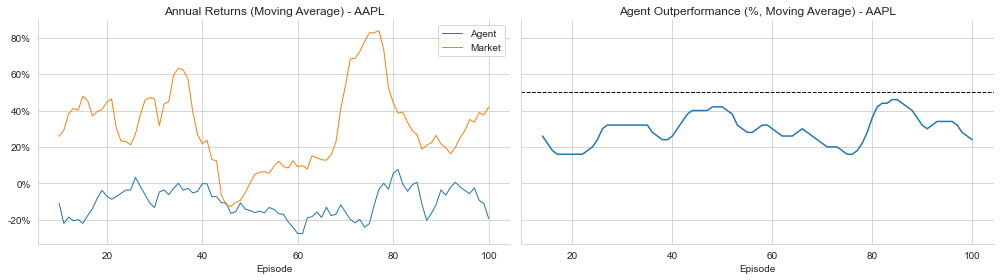

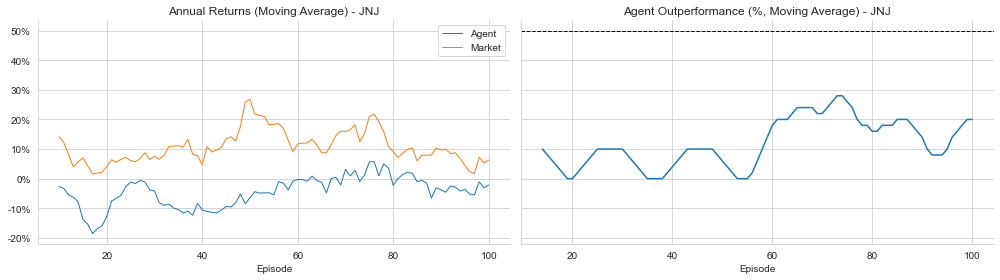

In [36]:
for ticker in tickers:
    results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                            'Agent': navs[ticker],
                            'Market': market_navs[ticker],
                            'Difference': diffs[ticker]}).set_index('Episode')

    results['Strategy Wins (%)'] = (results.Difference > 0).rolling(int(max_episodes*0.10)).sum()

    results.to_csv(results_path / 'results_{0}.csv'.format(ticker), index=False)
    
    # Evaluate results
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

    df1 = (results[['Agent', 'Market']]
        .sub(1)
        .rolling(int(max_episodes*0.10))
        .mean())
    df1.plot(ax=axes[0],
            title='Annual Returns (Moving Average) - {0}'.format(ticker),
            lw=1)

    df2 = results['Strategy Wins (%)'].div(int(max_episodes*0.10)).rolling(int(max_episodes*0.05)).mean()
    df2.plot(ax=axes[1],
            title='Agent Outperformance (%, Moving Average) - {0}'.format(ticker))

    for ax in axes:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax.xaxis.set_major_formatter(
            FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    axes[1].axhline(.5, ls='--', c='k', lw=1)

    sns.despine()
    fig.tight_layout()
    fig.savefig(results_path / 'performance_{0}'.format(ticker), dpi=300)